# ABC inference

In [1]:
%run -i ./preamble.py
%config InlineBackend.figure_format = 'retina'
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# dill.load_session("Geometric_Exponential.pkl")

<IPython.core.display.Javascript object>

In [3]:
import sys

print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("PyMC3 version:", pm.__version__)
print("Arviz version:", arviz.__version__)

tic()

Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
Numpy version: 1.20.1
PyMC3 version: 3.11.2
Arviz version: 0.11.1


<IPython.core.display.Javascript object>

In [4]:
FAST = False

if not FAST:
    numIters = 10
    numItersData = 15
    popSize = 1000
    timeout = 1000
else:
    numIters = 4
    numItersData = 8
    popSize = 100
    timeout = 30

smcArgs = {"timeout": timeout, "verbose": True}
smcArgs["numProcs"] = 40

<IPython.core.display.Javascript object>

In [5]:
# Create a pseudorandom number generator
rg = default_rng(1234)

# Parameters of the true model
freq = "geometric"
sev = "exponential"
thetaTrue = (0.8, 5)

# Setting the time horizon
T = 100

# Simulating the claim data
freqs, sevs = abcre.simulate_claim_data(rg, T, freq, sev, thetaTrue)

# Simulating the observed data
psi = abcre.Psi("sum")
xData = abcre.compute_psi(freqs, sevs, psi)

<IPython.core.display.Javascript object>

In [6]:
print("Number of zeros:", np.sum(xData == 0))
print("Mean summands:", np.mean(sevs))

Number of zeros: 19
Mean summands: 5.057404076350818


<IPython.core.display.Javascript object>

## Trying to recover both frequency and claim size distributions

In [7]:
params = ("p", "δ")
prior = abcre.IndependentUniformPrior([(0, 1), (0, 100)], params)
model = abcre.Model(freq, sev, psi, prior)

<IPython.core.display.Javascript object>

In [8]:
%time fit = abcre.smc(numIters, popSize, xData, model, **smcArgs)

Final population dists <= 1.51, ESS = 864
CPU times: user 12.7 s, sys: 1.58 s, total: 14.3 s
Wall time: 1min 6s


<IPython.core.display.Javascript object>

## Trying to recover just the claim sizes conditioned on the observed frequency counts

In [9]:
priorData = abcre.IndependentUniformPrior([(0, 100)], ("p", "δ"))
modelData = abcre.Model(freqs, sev, psi, priorData)
%time fitData = abcre.smc(numItersData, popSize, xData, modelData, **smcArgs)

Final population dists <= 1.14, ESS = 956
CPU times: user 16.6 s, sys: 1.64 s, total: 18.3 s
Wall time: 1min 14s


<IPython.core.display.Javascript object>

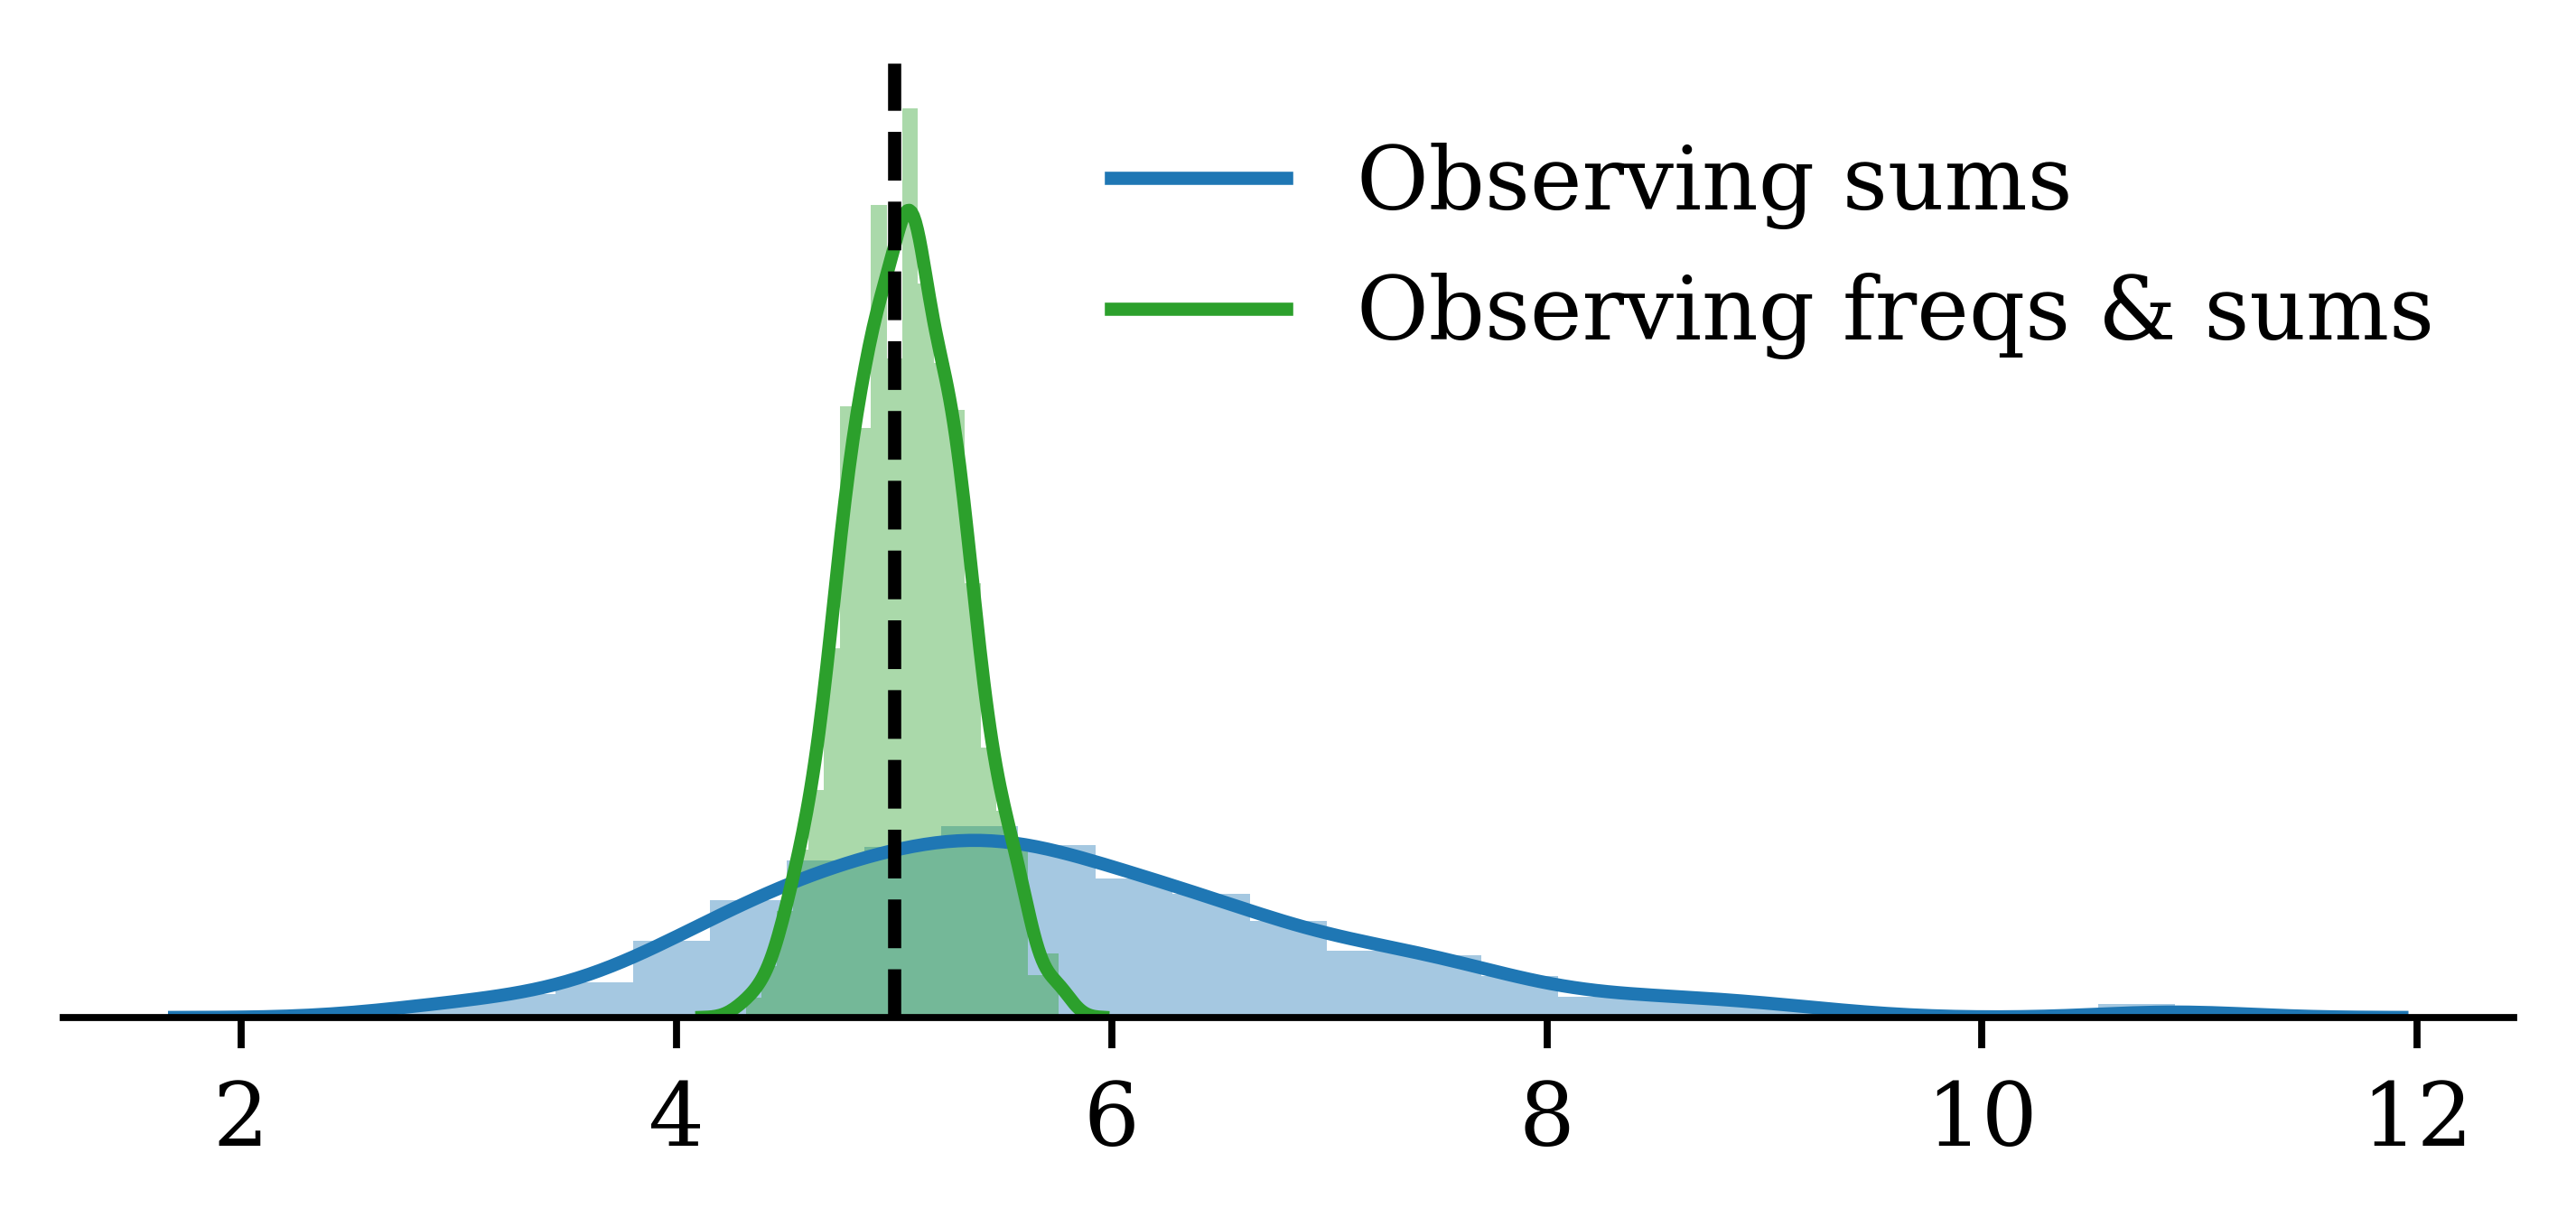

<IPython.core.display.Javascript object>

In [10]:
abcre.weighted_distplot(fit.samples[:, 1], fit.weights)
abcre.weighted_distplot(fitData.samples[:, 0], fitData.weights)
plt.axvline(thetaTrue[1], c="k", ls="--")
plt.yticks([])
sns.despine(left=True)
plt.legend(["Observing sums", "Observing freqs & sums"], frameon=False)

## Using summary statistics

In [11]:
from numba import njit


@njit(nogil=True)
def sumstats(x):
    return np.sum(x)


@njit(nogil=True)
def l1_dist(ssData, ssFake):
    return np.abs(ssData - ssFake)

<IPython.core.display.Javascript object>

In [12]:
%%time

fitSS = abcre.smc(
    numIters,
    popSize,
    xData,
    model,
    sumstats=sumstats,
    distance=l1_dist,
    **smcArgs
)

Final population dists <= 0.33, ESS = 869
CPU times: user 11.2 s, sys: 1.02 s, total: 12.3 s
Wall time: 1min 18s


<IPython.core.display.Javascript object>

In [13]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    p = pm.Uniform("p", 0, 1)
    δ = pm.Uniform("δ", 0, 100)

    # Log probability of the compound-sum variable
    def logp(t0, sumData):
        return T * np.log(1 - p) + (T - t0) * np.log(p / δ) - (1 - p) / δ * sumData

    exp_surv = pm.DensityDist(
        "X", logp, observed={"t0": np.sum(xData == 0), "sumData": np.sum(xData)}
    )
    
    %time trace = pm.sample(1000, tune=500, chains = 1, random_seed = 1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [δ, p]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 2.14 s, sys: 140 ms, total: 2.28 s
Wall time: 3.89 s


<IPython.core.display.Javascript object>

## MLE

In [14]:
t0 = np.sum(xData == 0)
sumData = np.sum(xData)


def logp(θ):
    p, δ = θ
    return T * np.log(1 - p) + (T - t0) * np.log(p / δ) - (1 - p) / δ * sumData


from scipy.optimize import minimize


def costFn(θ):
    return -logp(θ)


bnds = ((0, 1), (0, None))
x0 = np.array((0.5, 6.0))

minRes = minimize(costFn, x0, bounds=bnds)
print("Optimiser reports a success?", minRes.success)

print(minRes.x, thetaTrue)

pPartialMLE = minRes.x[0]
δPartialMLE = minRes.x[1]

Optimiser reports a success? True
[0.80999764 5.13677671] (0.8, 5)


<IPython.core.display.Javascript object>

## MLE using full information

In [15]:
pMLE = 1 - 1 / (freqs.mean() + 1)
δMLE = sevs.mean()

<IPython.core.display.Javascript object>

## Plot all together

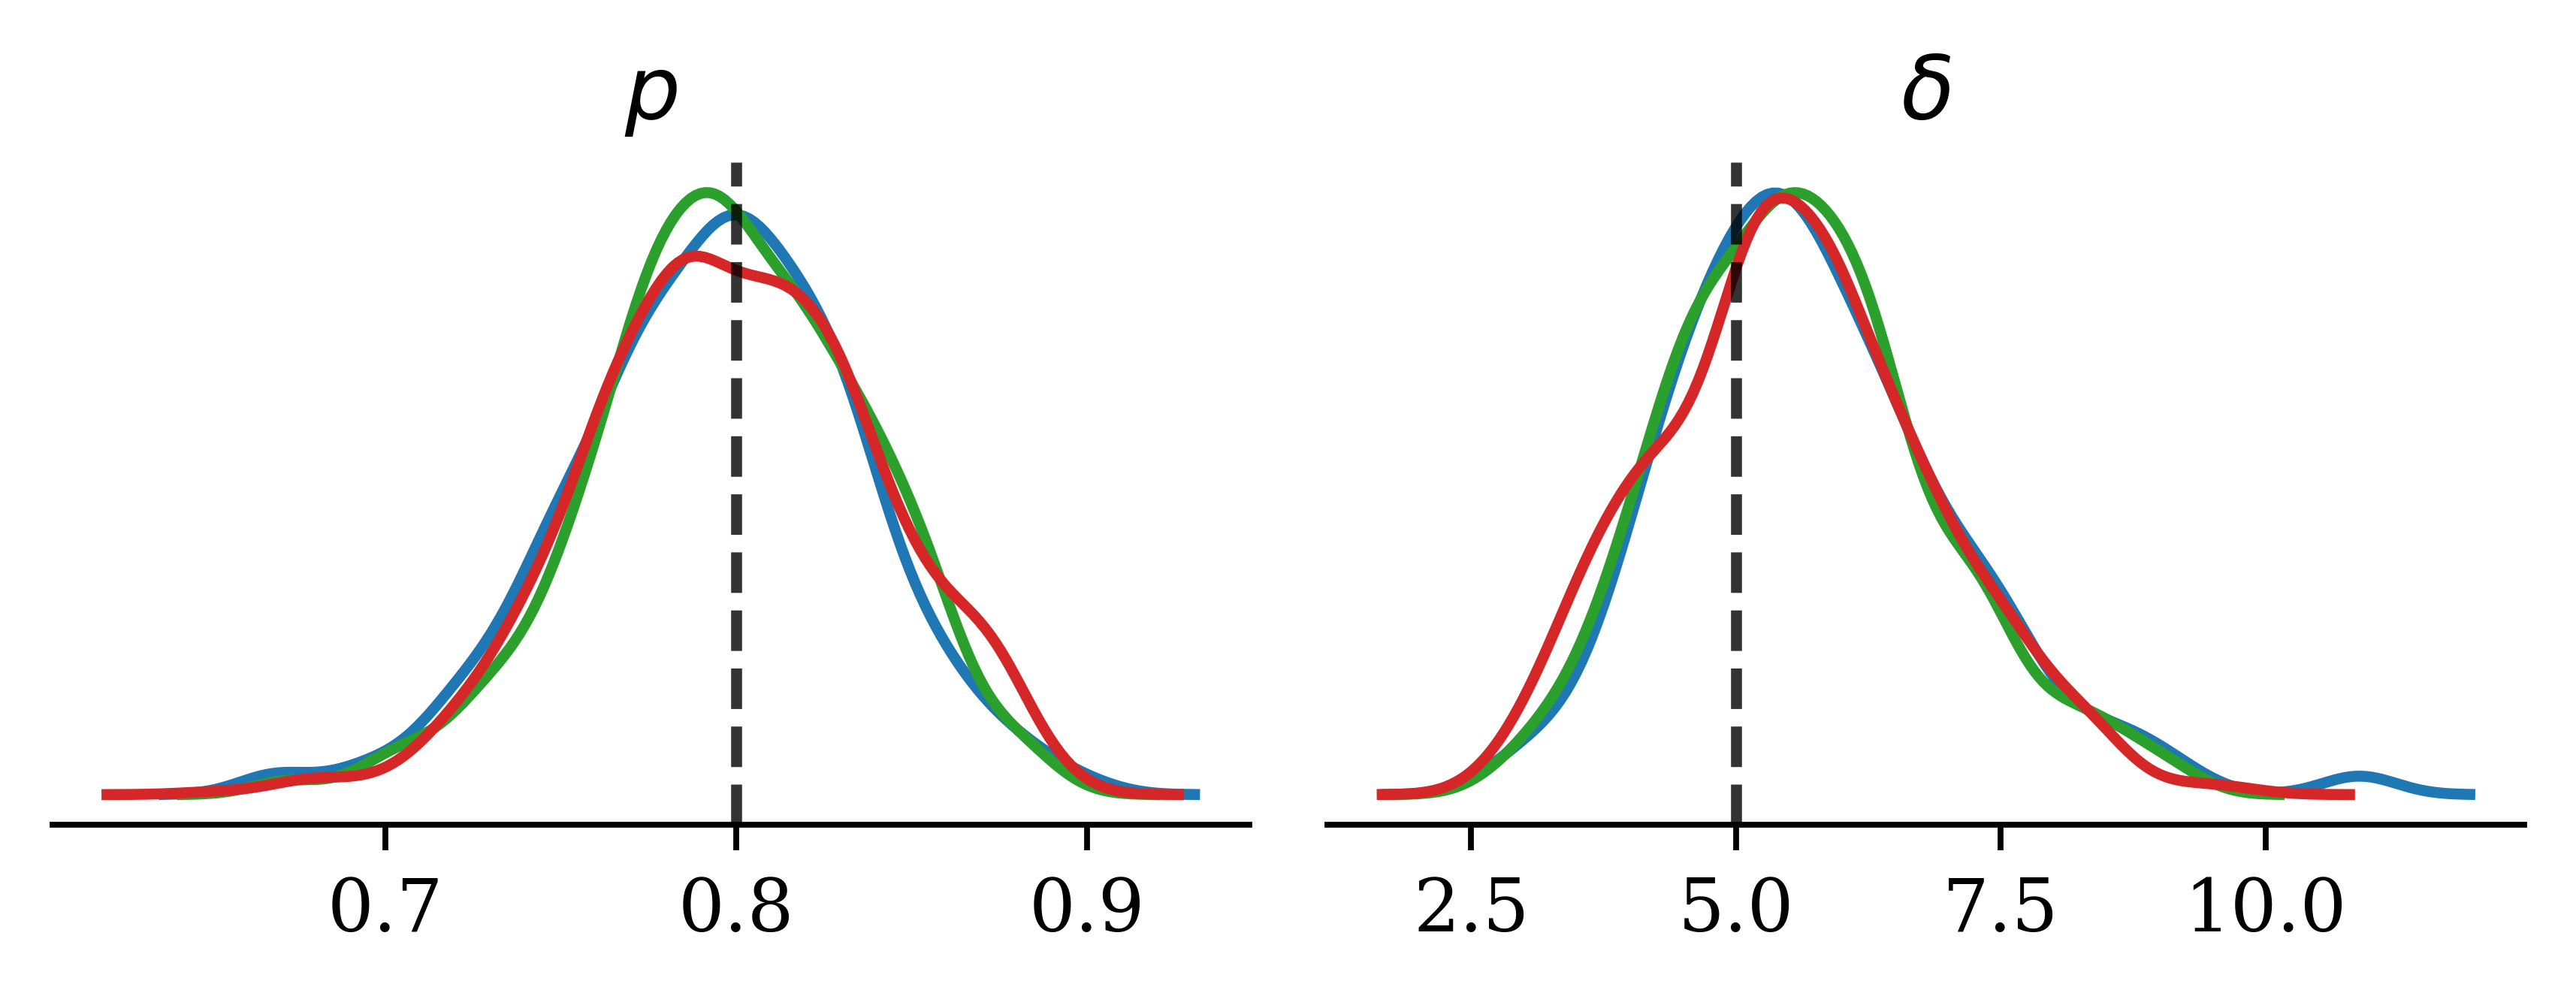

<IPython.core.display.Javascript object>

In [18]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)
nMCMC = len(trace.posterior["p"][0])

for l, param in enumerate(params):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    abcre.weighted_distplot(fit.samples[:, l], fit.weights, ax=axs[l], hist=False)
    abcre.weighted_distplot(fitSS.samples[:, l], fitSS.weights, ax=axs[l], hist=False)
    abcre.weighted_distplot(trace.posterior[param][0], np.ones(nMCMC) / nMCMC, ax=axs[l], hist=False)
    axs[l].legend([], frameon=False)
    axs[l].set_title("$" + param + "$")
    axs[l].set_yticks([])
    axs[l].axvline(thetaTrue[l], color="k", linestyle="dashed", alpha=0.8)

sns.despine(left=True)
# save_cropped("../Figures/geometric-exponential-posterior.pdf")

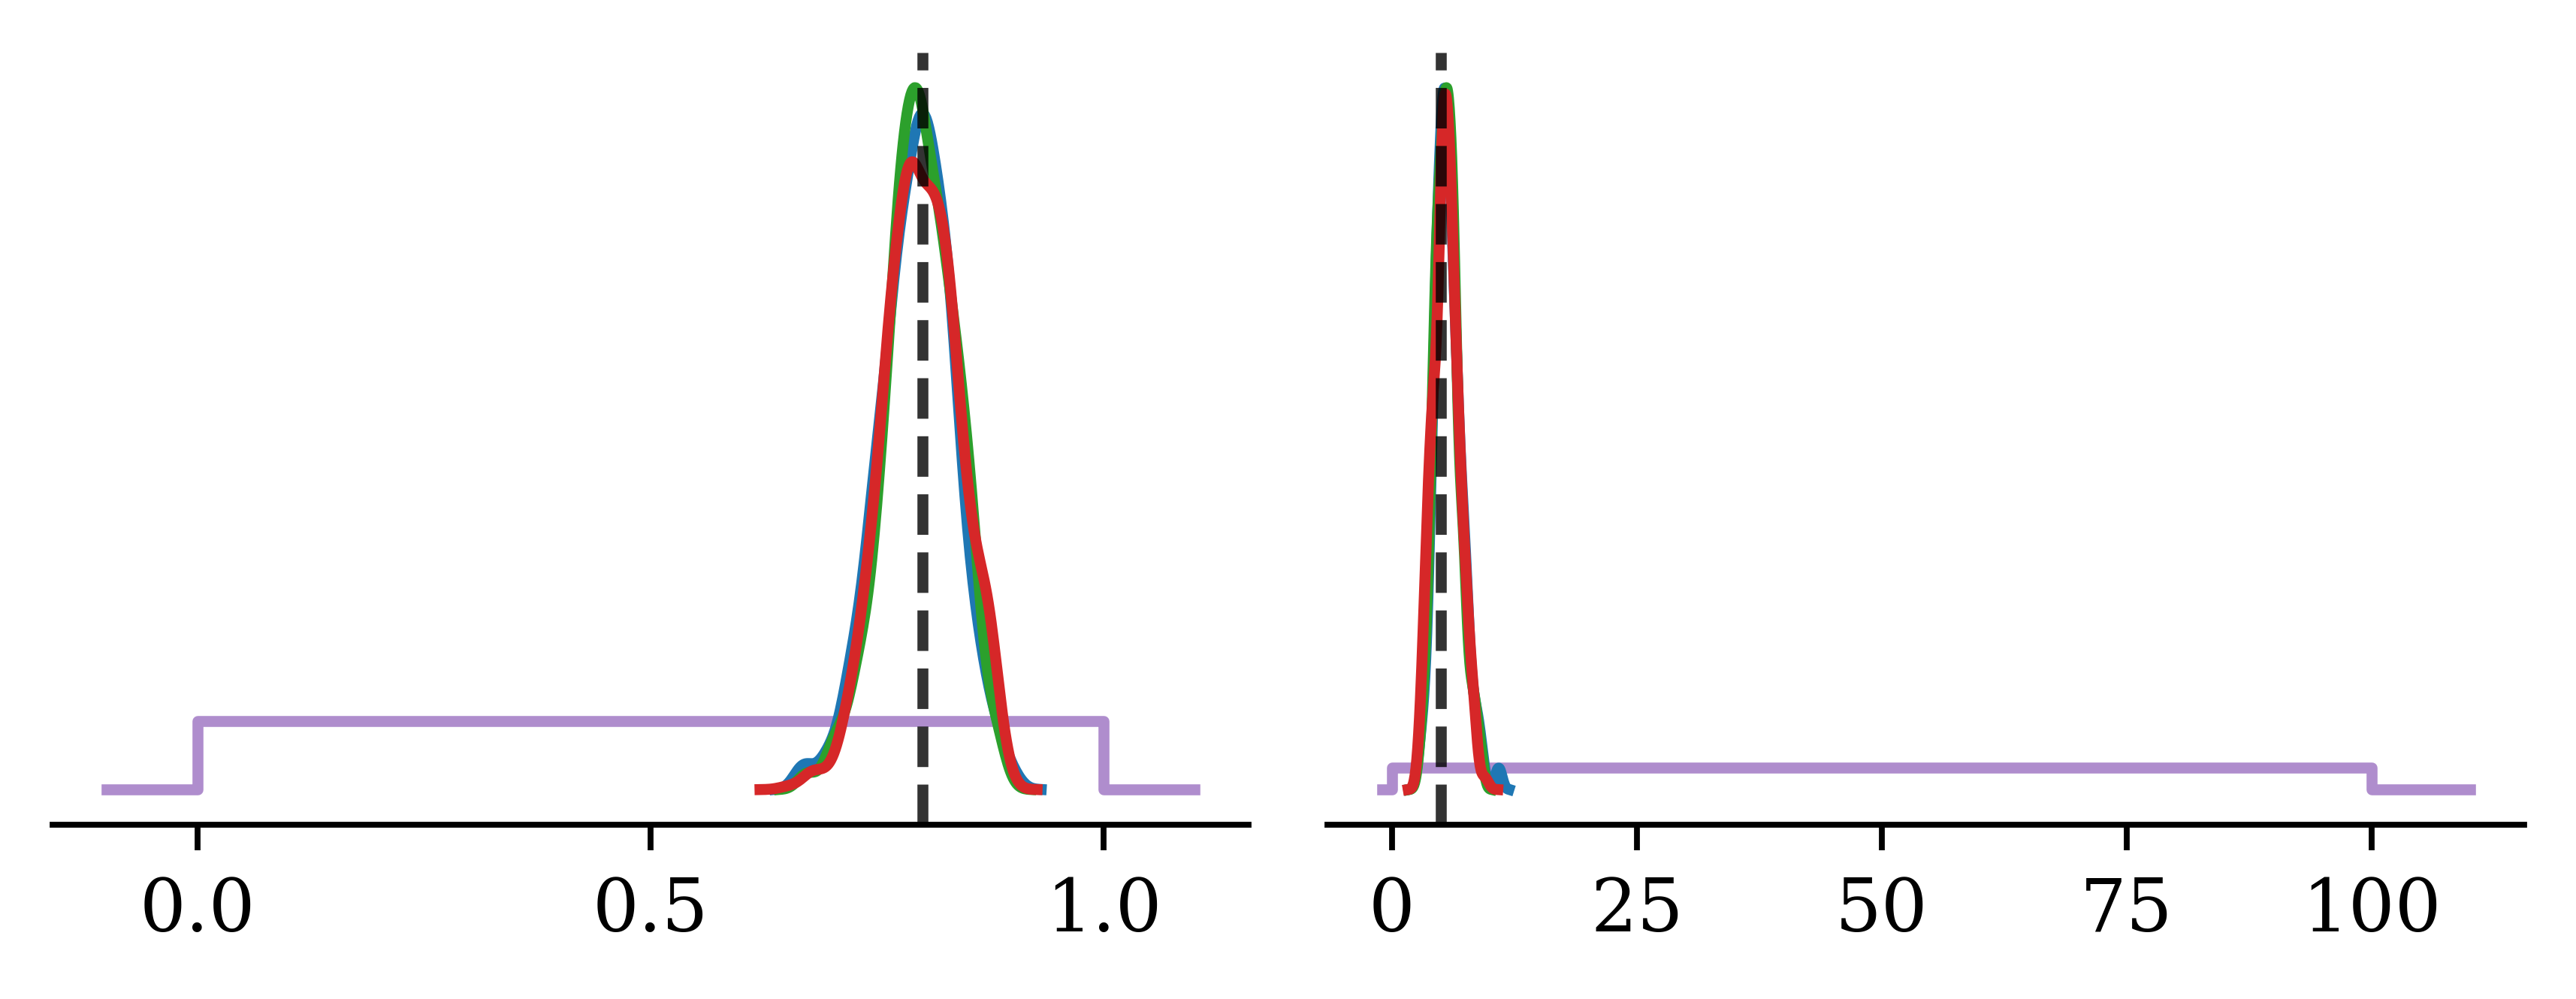

<IPython.core.display.Javascript object>

In [19]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l, param in enumerate(params):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    abcre.weighted_distplot(fit.samples[:, l], fit.weights, ax=axs[l], hist=False)
    abcre.weighted_distplot(fitSS.samples[:, l], fitSS.weights, ax=axs[l], hist=False)
    abcre.weighted_distplot(trace.posterior[param][0], np.ones(nMCMC) / nMCMC, ax=axs[l], hist=False)
    axs[l].legend([], frameon=False)
    # axs[l].set_title("$" + param + "$")
    axs[l].set_yticks([])
    axs[l].axvline(thetaTrue[l], color="k", linestyle="dashed", alpha=0.8)

draw_prior(prior, axs)
sns.despine(left=True)
save_cropped("../Figures/geometric-exponential-posterior-with-prior.pdf")

In [20]:
elapsed = toc()
print(f"Notebook time = {elapsed:.0f} secs = {elapsed/60:.2f} mins")

Notebook time = 230 secs = 3.83 mins


<IPython.core.display.Javascript object>

In [ ]:
dill.dump_session("Geometric_Exponential.pkl")